# CycleGAN with two-objective dualhead discriminator with bce and hinge losses 

There are two implementetions:

1. DiffAugment (look https://www.kaggle.com/unfriendlyai/diffaugment-is-all-you-need for details)

2. My own contribution two-objective dualhead discriminator with bce and hinge losses 

Why do I need such discriminator? We have only 300 Monet paintings and discriminator overfits quickly. Existing solutions are considered but they do not completely solve the problem of small amount of training data, which threatens to overfit the discriminator and the continious deterioration of the result. Successful results under such conditions are achieved by early stopping. A two-objective discriminator is proposed, which is expected to avoid the negative effects of overfitting the discriminator and the need for early stopping.







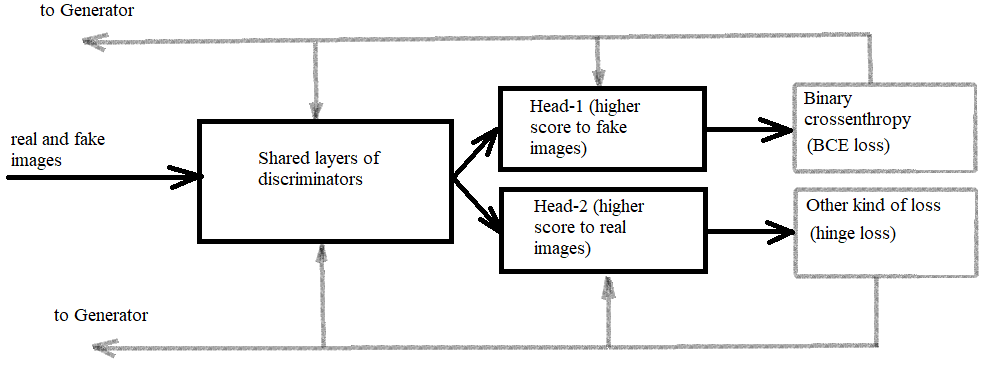

Main idea: shared layers are disturbed with two different losses and  discriminators cant overfit quickly

Related works: 

[Nguyen, T. et al. «Dual Discriminator Generative Adversarial Nets.» NIPS (2017).](https://arxiv.org/abs/1709.03831) - but discriminators have no shared layers there.

[Hoang, Q., Nguyen, T., Le, T., & Phung, D.Q. (2017). Multi-Generator Generative Adversarial Nets. ArXiv, abs/1708.02556](https://arxiv.org/abs/1708.02556) - discriminator and classificator have shared layers, but they are not both discriminators with different losses

In [101]:
BATCH_SIZE = 32

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np
import re
import os
try:
    from kaggle_datasets import KaggleDatasets
except:
    pass

In [102]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTO = tf.data.experimental.AUTOTUNE    
print(tf.__version__)

Number of replicas: 1
2.14.0


In [133]:
GCS_PATH = '../data/monet_example'

dataset_dir = os.path.join(os.path.expanduser("~"),"datasets", "handwriting", "IAM_Handwriting_Top50")
cropped_dir = os.path.join(dataset_dir, "cropped", "author")

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

FIRAUTH = tf.io.gfile.glob(os.path.join(cropped_dir, "000", "*.tfrec"))
# PHOTO_FILENAMES = tf.io.gfile.glob(os.path.join(cropped_dir, "150", "*.tfrec"))

print("# Monet TFREC files: ", len(MONET_FILENAMES))
# Take one record to inspect its features
for raw_record in tf.data.TFRecordDataset(MONET_FILENAMES[0]).take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    # Print the features
    for key, value in example.features.feature.items():
        print(f"key: {key} value: {value}")
        
print("Fir auth: ")
for raw_record in tf.data.TFRecordDataset(FIRAUTH[0]).take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    # Print the features
    for key, value in example.features.feature.items():
        print(f"key: {key} value: {value}")

# Monet TFREC files:  5
key: target value: bytes_list {
  value: "monet"
}

key: image_name value: bytes_list {
  value: "25c9904782"
}

key: image value: bytes_list {
  value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\002\002\003\001\001\001\001\000\000\000\000\000\000\000\000\006\007\004\005\003\010\t\002\000\n\001\377\304\000K\020\000\002\001\002\004\003\005\005\004\t\003\001\007\001\t\000\003\004\005\006\023\000\002\007#\0243C\010\022\025Sc\001\"$s\203

In [104]:
def data_augment_flip(image):
    image = tf.image.random_flip_left_right(image)
    return image

In [134]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    print(image)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    print(image)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    print(image)
    return image

In [135]:
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES).batch(1)


fast_photo_ds = load_dataset(PHOTO_FILENAMES).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_photo_ds = load_dataset(PHOTO_FILENAMES).take(1024).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_monet_ds = load_dataset(MONET_FILENAMES).batch(32*strategy.num_replicas_in_sync).prefetch(32)

Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("sub:0", shape=(None, None, 3), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("sub:0", shape=(None, None, 3), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("sub:0", shape=(None, None, 3), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("sub:0", shape=(None, None, 3), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)
Tensor("sub:0", shape=(None, None, 3), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)


In [107]:
def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    

        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
#     monet_ds = monet_ds.cache()
#     photo_ds = photo_ds.cache()
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
        
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    print("-=-=-=- get_gan_dataset -=-=-=-")
    print(monet_ds)
    print(photo_ds)
    print("-=-=-=- get_gan_dataset -=-=-=-")
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

def get_photo_dataset(photo_files, augment=None, repeat=False, shuffle=False, batch_size=1):


    photo_ds = load_dataset(photo_files)
    

        
    if repeat:
        photo_ds = photo_ds.repeat()
    if shuffle:
        photo_ds = photo_ds.shuffle(2048)


        
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
#     monet_ds = monet_ds.cache()
#     photo_ds = photo_ds.cache()
    if augment:
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
    
    photo_ds = photo_ds.prefetch(AUTO)
    
    
    return photo_ds



In [108]:
final_dataset = get_gan_dataset(MONET_FILENAMES, 
                                PHOTO_FILENAMES, 
                                augment=data_augment_flip, 
                                repeat=True, 
                                shuffle=True, 
                                batch_size=BATCH_SIZE
                               )
print(final_dataset)

-=-=-=- get_gan_dataset -=-=-=-
<_PrefetchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>
<_PrefetchDataset element_spec=TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None)>
-=-=-=- get_gan_dataset -=-=-=-
<_ZipDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None))>


In [109]:
with strategy.scope():

    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)

    mix3  = inception_model.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)

    inception_model = tf.keras.Model(inputs=inception_model.input, outputs=f0)
    inception_model.trainable = False

    
    
    def calculate_activation_statistics_mod(images,fid_model):
        print(images)
        act    = tf.cast(fid_model.predict(images), tf.float32)
        mu     = tf.reduce_mean(act, axis=0)
        mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
        mx     = tf.matmul(tf.transpose(mean_x), mean_x)
        vx     = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
        sigma  = vx - mx
        return mu, sigma
    myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(fid_monet_ds,inception_model)        
    fids=[]
    print(fids)

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
212/212 [==============================] - 99s 466ms/step
[]


In [110]:
with strategy.scope():
    def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):
        fid_epsilon = 1e-14
       
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))
#         isgood=tf.cast(tf.math.is_finite(covmean), tf.int32)
#         if tf.size(isgood)!=tf.math.reduce_sum(isgood):
#             return 0

        covmean = tf.cast(tf.math.real(covmean),tf.float32)
  
        tr_covmean = tf.linalg.trace(covmean)


        return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean


    
    
    def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):
                inp = layers.Input(shape=[256, 256, 3], name='input_image')
                x  = gen_model(inp)
                x=inception_model(x)
                fid_model = tf.keras.Model(inputs=inp, outputs=x)
                
                mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)

                fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)


                return fid_value

In [111]:
OUTPUT_CHANNELS = 3

def down_sample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    layer.add(layers.LeakyReLU())

    return layer

In [112]:
def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

In [113]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False),# (size, 128, 128, 64)
        down_sample(128, 4),                         # (size, 64, 64, 128)
        down_sample(256, 4),                         # (size, 32, 32, 256)
        down_sample(512, 4),                         # (size, 16, 16, 512)
        down_sample(512, 4),                         # (size, 8, 8, 512)
        down_sample(512, 4),                         # (size, 4, 4, 512)
        down_sample(512, 4),                         # (size, 2, 2, 512)
        down_sample(512, 4),                         # (size, 1, 1, 512)
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True),       # (size, 2, 2, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 4, 4, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 8, 8, 1024)
        up_sample(512, 4),                           # (size, 16, 16, 1024)
        up_sample(256, 4),                           # (size, 32, 32, 512)
        up_sample(128, 4),                           # (size, 64, 64, 256)
        up_sample(64, 4),                            # (size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 
    # (size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

# Headless discriminator (shared part)

In [114]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    
    down1 = down_sample(64, 4, False)(x)       # (size, 128, 128, 64)
    down2 = down_sample(128, 4)(down1)         # (size, 64, 64, 128)
    down3 = down_sample(256, 4)(down2)         # (size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (size, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (size, 33, 33, 512)

    return tf.keras.Model(inputs=inp, outputs=zero_pad2)

# Head for two-objective discriminator for Monet

In [115]:
def DHead():
    initializer = tf.random_normal_initializer(0., 0.02)
    print("DHEAD: ")
    inp = layers.Input(shape=[33, 33, 300], name='input_image')
    print(inp)
    x = inp
    print(x)
    
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (size, 30, 30, 1)
    print(last)

    return tf.keras.Model(inputs=inp, outputs=last)

# Discriminator for Photos (unchanged)

In [116]:
def DiscriminatorP():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    
    down1 = down_sample(64, 4, False)(x)       # (size, 128, 128, 64)
    down2 = down_sample(128, 4)(down1)         # (size, 64, 64, 128)
    down3 = down_sample(256, 4)(down2)         # (size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (size, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (size, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [117]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = DiscriminatorP() # differentiates real photos and generated photos
    dHead1 = DHead() # Head for BCE
    dHead2 = DHead() # Head for hinge loss


DHEAD: 
KerasTensor(type_spec=TensorSpec(shape=(None, 33, 33, 300), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 33, 33, 300), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 30, 30, 1), dtype=tf.float32, name=None), name='conv2d_643/BiasAdd:0', description="created by layer 'conv2d_643'")
DHEAD: 
KerasTensor(type_spec=TensorSpec(shape=(None, 33, 33, 300), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 33, 33, 300), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'")
KerasTensor(type_spec=TensorSpec(shape=(None, 30, 30, 1), dtype=tf.float32, name=None), name='conv2d_644/BiasAdd:0', description="created by layer 'conv2d_644'")


# CycleGAN with DiffAugment and two-objective discriminator

In [118]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        dhead1,        
        dhead2,        
        lambda_cycle=3,
        lambda_id=3,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.lambda_id = lambda_id
        self.dhead1 = dhead1
        self.dhead2 = dhead2
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn1,
        gen_loss_fn2,
        disc_loss_fn1,
        disc_loss_fn2,
        cycle_loss_fn,
        identity_loss_fn,
        aug_fn,

    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn1 = gen_loss_fn1
        self.gen_loss_fn2 = gen_loss_fn2
        self.disc_loss_fn1 = disc_loss_fn1
        self.disc_loss_fn2 = disc_loss_fn2
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.aug_fn = aug_fn

        self.step_num = 0
        
    def train_step(self, batch_data):
        print("-=-=-=-=- bd -=-=-=-=-")
        print(batch_data)
        real_monet, real_photo = batch_data
        batch_size = tf.shape(real_monet)[0]
        print(batch_size)
        print(real_monet)
        print(real_photo)
        with tf.GradientTape(persistent=True) as tape:
        
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            
            
            # Diffaugment
            both_monet = tf.concat([real_monet, fake_monet], axis=0)            
            
            aug_monet = self.aug_fn(both_monet)
            
            aug_real_monet = aug_monet[:batch_size]
            aug_fake_monet = aug_monet[batch_size:]
            
            
            # two-objective discriminator
            print("aug_fake_monet: ", aug_fake_monet)
            print(self.dhead1)
            print(self.m_disc(aug_fake_monet, training=True))
            disc_fake_monet1 = self.dhead1(self.m_disc(aug_fake_monet, training=True), training=True)
            disc_real_monet1 = self.dhead1(self.m_disc(aug_real_monet, training=True), training=True)
            disc_fake_monet2 = self.dhead2(self.m_disc(aug_fake_monet, training=True), training=True)
            disc_real_monet2 = self.dhead2(self.m_disc(aug_real_monet, training=True), training=True)

            monet_gen_loss1 = self.gen_loss_fn1(disc_fake_monet1) 
            monet_head_loss1 = self.disc_loss_fn1(disc_real_monet1, disc_fake_monet1)
            monet_gen_loss2 = self.gen_loss_fn2(disc_fake_monet2)
            monet_head_loss2 = self.disc_loss_fn2(disc_real_monet2, disc_fake_monet2)



            monet_gen_loss = (monet_gen_loss1 + monet_gen_loss2) * 0.4
            monet_disc_loss = monet_head_loss1 + monet_head_loss2


           
            
            # discriminator used to check, inputing real images

            disc_real_photo = self.p_disc(real_photo, training=True)
            # discriminator used to check, inputing fake images

            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss

            photo_gen_loss = self.gen_loss_fn1(disc_fake_photo)
            
            # evaluates discriminator loss

            photo_disc_loss = self.disc_loss_fn1(disc_real_photo, disc_fake_photo)


            # evaluates total generator loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle/ tf.cast(batch_size,tf.float32)) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle/ tf.cast(batch_size,tf.float32))

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss +  self.identity_loss_fn(real_monet, same_monet, self.lambda_id / tf.cast(batch_size,tf.float32))
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_id/ tf.cast(batch_size,tf.float32))



        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)
        

        # Heads gradients
        monet_head_gradients = tape.gradient(monet_head_loss1,
                                                      self.dhead1.trainable_variables)

        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients,
                                                  self.dhead1.trainable_variables))       

        monet_head_gradients = tape.gradient(monet_head_loss2,
                                                      self.dhead2.trainable_variables)
        self.m_disc_optimizer.apply_gradients(zip(monet_head_gradients,
                                                  self.dhead2.trainable_variables))     
        
        
        
        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_head_loss1": monet_head_loss1, 
            "monet_head_loss2": monet_head_loss2, 
            "disc_real_monet": disc_real_monet1, 
            "disc_fake_monet": disc_fake_monet1, 
            "disc_real_monet2": disc_real_monet2, 
            "disc_fake_monet2": disc_fake_monet2, 
            "monet_gen_loss": monet_gen_loss, 
            "photo_disc_loss": photo_disc_loss, 
            }


In [119]:
with strategy.scope(): # for TPU

    def discriminator_loss1(real, generated):
        real_loss = tf.math.minimum(tf.zeros_like(real), real-tf.ones_like(real))

        generated_loss = tf.math.minimum(tf.zeros_like(generated), -generated-tf.ones_like(generated))

        total_disc_loss = real_loss + generated_loss

        return tf.reduce_mean(-total_disc_loss * 0.5)

    def discriminator_loss2(real, generated):
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(real), real)
        total_disc_loss = real_loss + generated_loss

        return tf.reduce_mean(total_disc_loss * 0.5)



In [120]:
with strategy.scope():
    def generator_loss1(generated):
        return  tf.reduce_mean(-generated)

    def generator_loss2(generated):
        return tf.reduce_mean(tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated))

In [121]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_sum(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1 * 0.0000152587890625

In [122]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_sum(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss * 0.0000152587890625

In [123]:
with strategy.scope():
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738
# from https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py



    def DiffAugment(x, policy='', channels_first=False):
        if policy:
            if channels_first:
                x = tf.transpose(x, [0, 2, 3, 1])
            for p in policy.split(','):
                for f in AUGMENT_FNS[p]:
                    x = f(x)
            if channels_first:
                x = tf.transpose(x, [0, 3, 1, 2])
        return x


    def rand_brightness(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
        x = x + magnitude
        return x


    def rand_saturation(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
        x_mean = tf.reduce_sum(x, axis=3, keepdims=True) * 0.3333333333333333333
        x = (x - x_mean) * magnitude + x_mean
        return x


    def rand_contrast(x):
        magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
        x_mean = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True) * 5.086e-6
        x = (x - x_mean) * magnitude + x_mean
        return x

    def rand_translation(x, ratio=0.125):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
        translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
        grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
        grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
        x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
        x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
        return x


    def rand_cutout(x, ratio=0.5):
        batch_size = tf.shape(x)[0]
        image_size = tf.shape(x)[1:3]
        cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
        offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
        offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
        grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
        cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
        mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
        cutout_grid = tf.maximum(cutout_grid, 0)
        cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
        mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
        x = x * tf.expand_dims(mask, axis=3)
        return x


    AUGMENT_FNS = {
        'color': [rand_brightness, rand_saturation, rand_contrast],
        'translation': [rand_translation],
        'cutout': [rand_cutout],
}
    def aug_fn(image):
        return DiffAugment(image,"color,translation,cutout")

In [124]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)

In [125]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator, dHead1,  dHead2
    )



# 30 epochs with lr 2e-4

In [126]:
with strategy.scope():

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn1 = generator_loss1,
        gen_loss_fn2 = generator_loss2,
        disc_loss_fn1 = discriminator_loss1,
        disc_loss_fn2 = discriminator_loss2,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss,
        aug_fn = aug_fn ,


    )

In [127]:
# With the Monet example on an M1 Max each epoch step took ~22 seconds meaning it would take ~9hrs * # epochs ~= 10 days
print(final_dataset)
cycle_gan_model.fit(final_dataset,steps_per_epoch=1407, epochs=26)
FID(fid_photo_ds,monet_generator) 

<_ZipDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None))>
Epoch 1/26
-=-=-=-=- bd -=-=-=-=-
(<tf.Tensor 'IteratorGetNext:0' shape=(32, 256, 256, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 256, 256, 3) dtype=float32>)
Tensor("strided_slice:0", shape=(), dtype=int32)
Tensor("IteratorGetNext:0", shape=(32, 256, 256, 3), dtype=float32)
Tensor("IteratorGetNext:1", shape=(32, 256, 256, 3), dtype=float32)
aug_fake_monet:  Tensor("strided_slice_31:0", shape=(32, 256, 256, 3), dtype=float32)
Tensor("model_20/zero_padding2d_9/Pad:0", shape=(32, 33, 33, 512), dtype=float32)


ValueError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/var/folders/5p/h5nj056s2cl3dcc84j7j23xh0000gn/T/ipykernel_79517/2382719185.py", line 90, in train_step
        disc_fake_monet1 = self.dhead1(self.m_disc(aug_fake_monet, training=True), training=True)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_22" is incompatible with the layer: expected shape=(None, 33, 33, 300), found shape=(32, 33, 33, 512)


# 8 epochs with lr 1e-4

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
with strategy.scope():

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn1 = generator_loss1,
        gen_loss_fn2 = generator_loss2,
        disc_loss_fn1 = discriminator_loss1,
        disc_loss_fn2 = discriminator_loss2,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss,
        aug_fn = aug_fn ,
    )

In [ ]:
cycle_gan_model.fit(final_dataset,steps_per_epoch=1407, epochs=18)
FID(fid_photo_ds,monet_generator) 

# 8 epochs with lr 1e-5

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5)

In [ ]:
with strategy.scope():

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn1 = generator_loss1,
        gen_loss_fn2 = generator_loss2,
        disc_loss_fn1 = discriminator_loss1,
        disc_loss_fn2 = discriminator_loss2,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss,
        aug_fn = aug_fn ,
    )

In [ ]:
cycle_gan_model.fit(final_dataset,steps_per_epoch=1407, epochs=8)
FID(fid_photo_ds,monet_generator) 

In [ ]:
ds_iter = iter(photo_ds)
for n_sample in range(8):
        example_sample = next(ds_iter)
        generated_sample = monet_generator(example_sample)
        
        f = plt.figure(figsize=(32, 32))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [ ]:
ds_iter = iter(monet_ds)
for n_sample in range(8):

        example_sample = next(ds_iter)
        generated_sample = photo_generator(example_sample)
        
        f = plt.figure(figsize=(24, 24))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [ ]:
import PIL
! mkdir ../images

In [ ]:
%%time
i = 1
for img in fast_photo_ds:
    prediction = monet_generator(img, training=False).numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    for pred in prediction:
        im = PIL.Image.fromarray(pred)
        im.save("../images/" + str(i) + ".jpg")
        i += 1
    

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

In [ ]:

dHead1.save_weights("dHead1.h5")
dHead2.save_weights("dHead2.h5")

photo_generator.save_weights("photo_generator.h5")
monet_generator.save_weights("monet_generator.h5")

photo_discriminator.save_weights("photo_discriminator.h5")
monet_discriminator.save_weights("monet_discriminator.h5")